<a href="https://colab.research.google.com/github/aerjayc/coe197z-hw2/blob/master/mnist_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.datasets import mnist
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

!git clone https://github.com/baudm/ee298z.git
!cp ee298z/hw2/mnist_cnn.h5 .
from ee298z.hw2.transforms import corrupt_mnist_copy

!mkdir models

Using TensorFlow backend.


Cloning into 'ee298z'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 72 (delta 38), reused 41 (delta 17), pack-reused 0
Unpacking objects: 100% (72/72), done.


## Preprocessing

In [2]:
# Import dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Corrupt images
x_train_corrupt = corrupt_mnist_copy(x_train)
x_test_corrupt  = corrupt_mnist_copy(x_test)

# reshape to (28, 28, 1) and normalize input images
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_train_corrupt = np.reshape(x_train_corrupt, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_test_corrupt = np.reshape(x_test_corrupt, [-1, image_size, image_size, 1])

x_train = x_train.astype('float32') / 255
x_train_corrupt = x_train_corrupt.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_test_corrupt = x_test_corrupt.astype('float32') / 255

11493376/11490434 [==============================] - 0s 0us/step


## Input Visualization

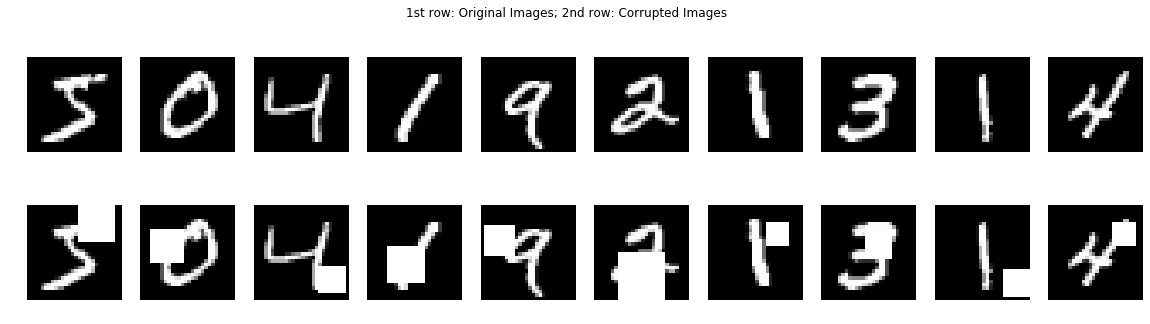

In [3]:
from plotting import show_images

N = 10
original_imgs = x_train[0:N].reshape((N, image_size, image_size)) * 255
corrupted_imgs = x_train_corrupt[0:N].reshape((N, image_size, image_size)) * 255

title = '1st row: Original Images; 2nd row: Corrupted Images'
fig, ax = show_images(original_imgs, corrupted_imgs, title=title)

## Model

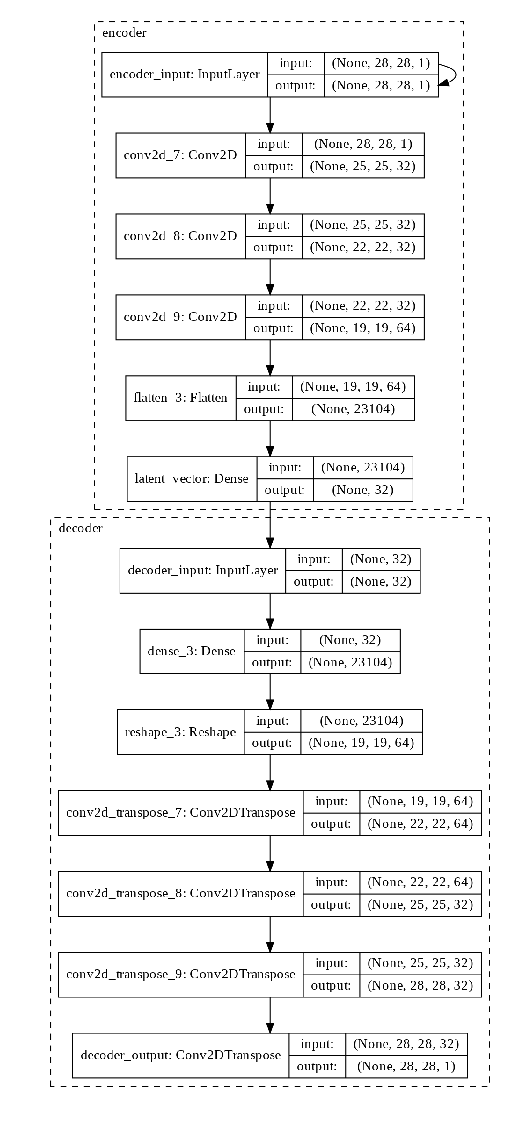

In [11]:
from autoencoder import make_autoencoder
from plotting import plot_model_summary

# network parameters
input_shape = x_train.shape[1:] # (28,28,1)
batch_size = 32
kernel_size = 4
latent_dim = 32
strides = 1
padding = 'valid'

# encoder/decoder number of CNN layers and filters per layer
layer_filters = [32, 32, 64]

loss = 'mse'
optimizer = 'adam'

autoencoder = make_autoencoder(input_shape, layer_filters, kernel_size, latent_dim,
                               strides, padding, loss=loss, optimizer=optimizer)
plot_model_summary(autoencoder, to_file='autoencoder.png')

## Training

In [12]:
# train the autoencoder
earlystopping = EarlyStopping(min_delta=0.0001, verbose=1,
                              restore_best_weights=True, patience=0)

history = autoencoder.fit(x_train_corrupt,
                          x_train,
                          validation_data=(x_test_corrupt, x_test),
                          epochs=10,
                          batch_size=batch_size,
                          callbacks=[earlystopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 42s 697us/step - loss: 0.0268 - val_loss: 0.0134
Epoch 2/10
60000/60000 [==============================] - 41s 683us/step - loss: 0.0123 - val_loss: 0.0115
Epoch 3/10
60000/60000 [==============================] - 41s 681us/step - loss: 0.0107 - val_loss: 0.0106
Epoch 4/10
60000/60000 [==============================] - 41s 679us/step - loss: 0.0098 - val_loss: 0.0102
Epoch 5/10
60000/60000 [==============================] - 41s 679us/step - loss: 0.0092 - val_loss: 0.0103
Restoring model weights from the end of the best epoch
Epoch 00005: early stopping


## Loss plot

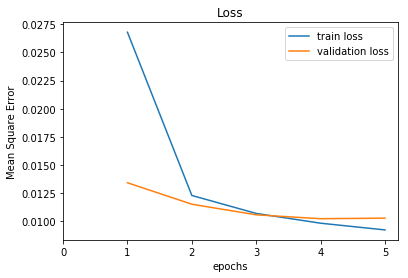

In [13]:
from plotting import plot_losses
plot_losses(history)

## Predictions

In [0]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_corrupt)

### Output Visualization

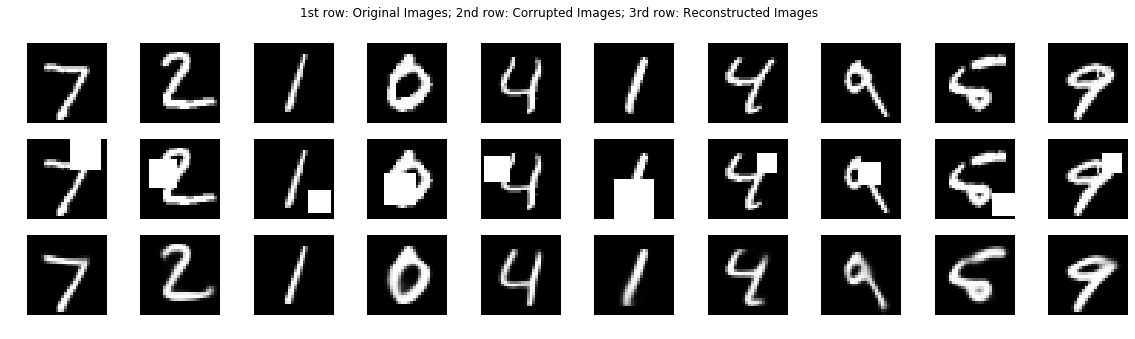

In [15]:
N = 10
original_imgs = x_test[0:N].reshape((N, image_size, image_size))
corrupted_imgs = x_test_corrupt[0:N].reshape((N, image_size, image_size))
reconstructed_imgs = x_decoded[0:N].reshape((N, image_size, image_size))

title = '1st row: Original Images; 2nd row: Corrupted Images; 3rd row: Reconstructed Images'
fig, ax = show_images(original_imgs,
                      corrupted_imgs,
                      reconstructed_imgs,
                      title=title)

## Benchmarks

In [17]:
from ee298z.hw2.benchmark_keras import test_model

test_model(autoencoder, x_test.reshape(-1,28,28), y_test, batch_size=100)

Classifier score: 97.05
SSIM score: 95.23


In [0]:
autoencoder.save(f'models/autoencoder_97.05cs_95.23ssim.hdf5')

# Discussion

The model was based on sir Atienza's code [here](https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter3-autoencoders/denoising-autoencoder-mnist-3.3.1.py). It already performs well prior to any tweaking, to the extent that it passes the baseline benchmark scores (it achieved a classifier score of $93.83\%$ and a SSIM score of $89.40\%$). To get better results than this, some of the tunable parameters (e.g. `layer_filters`, `latent_dim`, `kernel_size`, `strides`, and `padding`) were tweaked while observing their effects on the metrics and benchmarks. The table below shows the tweaks made and the corresponding metrics and benchmarks in chronological order.

The table shows that the one of the most significant contributors to the model's increase in performance is the jump of `latent_dim` from `16` to `32`, which corresponds to a $1.47\%$ increase in classifier score and a $3.83\%$ increase in SSIM score. Other tweaks only marginally improved the performance, but when aggregated, the model was able to achieve a classifier score of $97.05\%$ and a SSIM score of $95.23\%$ (as shown above as well as on the table).

| latent dim | layer_filters | kernel_size | strides | padding | loss function | optimizer | epochs | classifier score | SSIM score | final val_loss |
|-|-|-|-|-|-|-|-|-|-|-|
| 16 | [32, 64] | 3 | 2 | 'same' | mse | adam | 10 | 93.83 | 89.40 |  |
| 16 | [32, 64] | 3 | 2 | 'same' | mse | adam | __20__ | 94.67 | 89.93 |  |
| __32__ | [32, 64] | 3 | 2 | 'same' | mse | adam | 8 | 96.14 | 93.86 | 0.0122 |
| ~32~ | ~[32, 32, 64]~ | ~3~ | ~1~ | ~'same'~ | ~mse~ | ~adam~ | ~5~ | ~96.96~ | ~94.94~ | ~0.0105~ |
| ~32~ | ~[32, 32, 64]~ | ~3~ | ~1~ | ~'valid'~ | ~mse~ | ~adam~ | ~5~ | ~97.01~ | ~95.22~ | ~0.0104~ |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.04 | 95.15 | 0.0104 |
| 32 | [32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 96.44 | 94.54 | 0.0112 |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.03 | 95.51 | 0.0103 |
| 32 | [32, 32, 64] | 4 | 1 | 'valid' | mse | adam | 5 | 97.05 | 95.23 | 0.0103 |


The loss function used was Mean Squared Error since we want to correct the autoencoder on the pixel-level so it can approximate the input well.

The optimizer used was Adam. RMSprop and SGD were also tried, but the former seemed to settle at high loss levels, while the latter took too long (many more epochs compared to Adam) to get results.

The `EarlyStopping` callback function was used during training so that training is more time-efficient. It also makes it so that the final weights of the model are those that correspond to the best validation loss value.

Note that 2 rows in the table above are strike-throughed. This is because it didn't have the correct output shape (it had a shape of `(32,32,1)`) due to the mismatch between the parameters used.